This notebook shows small but apparently significant differences between the cost-per-patient between EMIS and TPP (in particular).

A difference of just 10p per patient would be £5m nationally, so worth looking at in more depth.

The main thing to do next is control for list demographics, because London is overwhelmingly young and overwhelmingly EMIS.


In [27]:
from ebmdatalab import bq
sql = """SELECT
  rx.month,
  rx.practice,
  SUM(net_cost)/prac.total_list_size AS cost_per_patient,
  vendors.Principal_Supplier,
  prac.total_list_size AS total_patients
FROM
  ebmdatalab.hscic.normalised_prescribing_standard rx
INNER JOIN
  `ebmdatalab.hscic.practice_statistics` prac
ON
  prac.practice = rx.practice AND prac.month = rx.month
INNER JOIN
  ebmdatalab.alex.vendors vendors
ON
  vendors.ODS = rx.practice AND vendors.DATE = rx.month
WHERE total_list_size > 1000
GROUP BY
  rx.month,
  rx.practice,
  vendors.Principal_Supplier,
  prac.total_list_size"""
df = bq.cached_read(sql, csv_path='cost_per_patient.csv')  

In [31]:
df['Principal_Supplier'] = df['Principal_Supplier'].str.strip()

In [56]:
df[df['month'] == "2019-05-01"].groupby("Principal_Supplier")['cost_per_patient'].mean()

Principal_Supplier
EMIS         12.274984
Microtest    15.036377
TPP          12.778642
Vision       11.957095
Name: cost_per_patient, dtype: float64

In [33]:
df2 = df[df['total_patients'] > 1500]
df2.sort_values("cost_per_patient").tail()

,month,practice,cost_per_patient,Principal_Supplier,total_patients
274140,2016-04-01 00:00:00+00:00,H84608,72.085460,INPS,2009
270737,2016-08-01 00:00:00+00:00,H84608,74.329043,INPS,1965
59444,2017-09-01 00:00:00+00:00,J83642,74.561277,TPP,1777
282870,2017-05-01 00:00:00+00:00,H84608,76.500187,Vision,1874
276360,2017-03-01 00:00:00+00:00,H84608,84.853340,Vision,1913


In [51]:
df2.month.max()

Timestamp('2019-05-01 00:00:00+0000', tz='UTC')

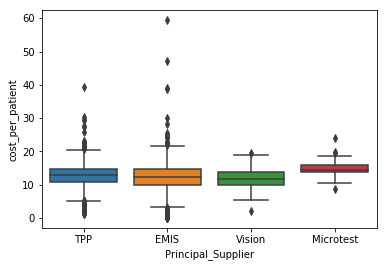

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

ax = sns.boxplot(x="Principal_Supplier", y="cost_per_patient", data=df2[df2['month'] == "2019-05-01"])
plt.show()

In [45]:
means = df2[df2.Principal_Supplier == 'EMIS'].groupby(["month", "Principal_Supplier"]).mean()['cost_per_patient'].reset_index()
means.head()

,month,Principal_Supplier,cost_per_patient
0,2016-01-01 00:00:00+00:00,EMIS,12.229105
1,2016-02-01 00:00:00+00:00,EMIS,12.178012
2,2016-03-01 00:00:00+00:00,EMIS,12.803824
3,2016-04-01 00:00:00+00:00,EMIS,12.892131
4,2016-05-01 00:00:00+00:00,EMIS,12.340288


In [48]:
df3 = df2.copy()
df4 = df3.merge(means, how="inner", left_on=["month"], right_on=["month"])
df4['cost_per_patient_emis_delta'] = df4['cost_per_patient_y'] - df4['cost_per_patient_x']
df4.head()

,month,practice,cost_per_patient_x,Principal_Supplier_x,total_patients,Principal_Supplier_y,cost_per_patient_y,cost_per_patient_emis_delta
0,2016-02-01 00:00:00+00:00,C81055,16.893858,EMIS,3727,EMIS,12.178012,-4.715847
1,2016-02-01 00:00:00+00:00,E83632,9.269672,Unknown,4058,EMIS,12.178012,2.908339
2,2016-02-01 00:00:00+00:00,F81042,12.522993,EMIS,24386,EMIS,12.178012,-0.344981
3,2016-02-01 00:00:00+00:00,L81006,13.082298,Unknown,3816,EMIS,12.178012,-0.904287
4,2016-02-01 00:00:00+00:00,N81023,15.057615,Unknown,5049,EMIS,12.178012,-2.879604


/home/seb/.local/lib/python3.7/site-packages/seaborn/relational.py:792: FutureWarning: Converting timezone-aware DatetimeArray to timezone-naive ndarray with 'datetime64[ns]' dtype. In the future, this will return an ndarray with 'object' dtype where each element is a 'pandas.Timestamp' with the correct 'tz'.
	To accept the future behavior, pass 'dtype=object'.
	To keep the old behavior, pass 'dtype="datetime64[ns]"'.
  x, y = np.asarray(x), np.asarray(y)
/home/seb/.local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


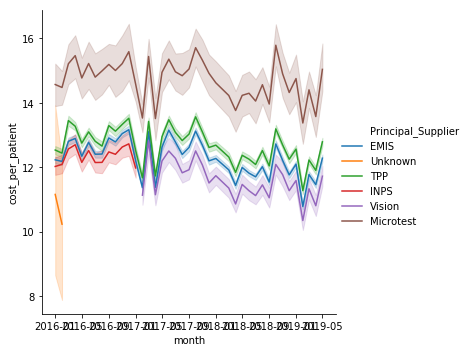

In [37]:
sns.relplot(x="month", y="cost_per_patient", hue="Principal_Supplier", kind="line", data=df2);

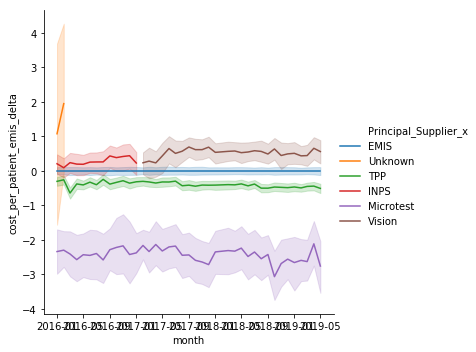

In [50]:
sns.relplot(x="month", y="cost_per_patient_emis_delta", hue="Principal_Supplier_x", kind="line", data=df4);